# Install libraries

First we install the packages and Mount the google drive as follows:

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/mydir')

# Define the path for the folder where you want to clone the repository
folder_path = '/content/mydir/MyDrive/qheom'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

# Change the current working directory to the folder where you want to clone the repository
os.chdir(folder_path)

# Clone the GitHub Repository into the specified folder
#!git clone https://github.com/XiaohanDan97/QHEOM .

Mounted at /content/mydir


In [ ]:
!pip install qiskit==1.2.4
!pip install qiskit_aer==0.15.1
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.6 MB/s eta 0:00:00


#Import functions, read the propagator, parameters

In [ ]:
#the code in the folder
import qfunc as qf
import dilate_circuit as dc
import walsh_gray_optimization as wo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator,QasmSimulator
from qiskit.quantum_info.operators import Operator

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakePerth, FakeLimaV2

In [ ]:
from qiskit import qpy

In [ ]:
s1 = ' '
class Parameter:

  #the number of electronic states
  ndvr = 2
  #the length of Reduced Density Matrix
  Nmat = ndvr**2

  #number of steps for propagator G(t)
  Nstep_bent = 10000 #bent
  Nstep_linear = 35000 #linear

  #initial the rho(t=0) at donor state |D>
  rho0 = np.array(([[1.0,0.0],[0.0,0.0]]),dtype=np.complex128)

  #setup the vector from the initial rho
  vec_rho0 = rho0.reshape(Nmat)

  def __init__(self, mode="full"):

    self.mode = mode

    #encode the full Reduced Density Matrix
    if(self.mode=="full"):
      self.site_dict = {1:'00',2:'01',3:'10',4:'11'}
      #the projection subspace
      self.proj_state_list = [0,1,2,3]
      #the number of qubits for the vectorize state vector
      self.Nqubit = 2

    #encode the population
    if(self.mode=="pop"):
      self.site_dict = {1:'0',2:'1'}
      self.proj_state_list = [0,3]
      self.Nqubit = 1

    #the length of statevector
    self.Nvec = 2**self.Nqubit

    self.ini_state = np.zeros(self.Nvec,dtype=np.complex_)
    for i in range(self.Nvec):
      self.ini_state[i] = self.vec_rho0[self.proj_state_list[i]]

    self.norm_rho0 = LA.norm(self.ini_state,2)
    self.ini_state /= self.norm_rho0

#"full" for projection subspace S={DD,DA,AD,AA}
#"pop" for projection subspace S={DD,AA}
pa=Parameter(mode = "full")

read the propagator from HEOM calculation

In [ ]:
os.chdir('./Gt_linear_pipi-ct1_nl3c7nb40')
folder_name=os.getcwd()
print('folder now',folder_name)
time_linear, Gt_linear0 = qf.read_superoper_array(pa.Nstep_linear,pa)
os.chdir('../Gt_bent_pipi-ct1_nl4c7nb30')
time_bent, Gt_bent0 = qf.read_superoper_array(pa.Nstep_bent,pa)
os.chdir('../')

Gt_linear = qf.proj(Gt_linear0,pa.proj_state_list)
Gt_bent = qf.proj(Gt_bent0,pa.proj_state_list)

folder now /content/mydir/MyDrive/qheom/Gt_linear_pipi-ct1_nl3c7nb40


#Classical part
calculate the time evolution of state vector from propagator:
$|\Phi(t)\rangle = G(t) |\Phi(0)\rangle$

In [ ]:
Rhot_bent = np.zeros((pa.Nvec,pa.Nstep_bent),dtype=np.complex128)
Rhot_linear = np.zeros((pa.Nvec,pa.Nstep_linear),dtype=np.complex128)

for istep in range(pa.Nstep_bent):
  vec_rdo = Gt_bent[istep,:,:]@pa.ini_state
  Rhot_bent[:,istep] = vec_rdo

for istep in range(pa.Nstep_linear):
  vec_rdo = Gt_linear[istep,:,:]@pa.ini_state
  Rhot_linear[:,istep] = vec_rdo

print('the classical propagation done')

the classical propagation done


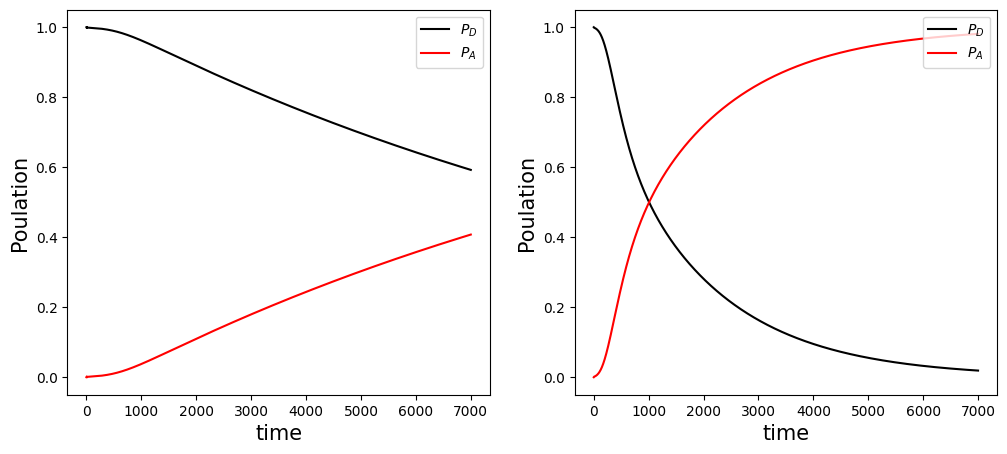

In [ ]:
#plot
plt.figure(figsize=(12, 5))

plt.subplot(121)

plt.plot(time_bent, Rhot_bent[0,:].real,'k-', label = "$P_D$")
plt.plot(time_bent, Rhot_bent[3,:].real,'r-', label = "$P_A$")
#plt.plot(time_bent, Rhot_bent[1,:].real,'g-', label = r'$Re \rho_{01}$')
#plt.plot(time_bent, Rhot_bent[1,:].imag,'b-', label = r'$Im \rho_{01}$')
plt.xlabel('time',fontsize=15)
plt.ylabel('Poulation',fontsize=15)
plt.legend(loc = 'upper right')

plt.subplot(122)
plt.subplots_adjust(wspace=0.2)

plt.plot(time_linear, Rhot_linear[0,:].real,'k-', label = "$P_D$")
plt.plot(time_linear, Rhot_linear[3,:].real,'r-', label = "$P_A$")
#plt.plot(time_linear, Rhot_linear[1,:].real,'g-', label = r'$Re \rho_{01}$')
#plt.plot(time_linear, Rhot_linear[1,:].imag,'b-', label = r'$Im \rho_{01}$')
plt.xlabel('time',fontsize=15)
plt.ylabel('Poulation',fontsize=15)
plt.legend(loc = 'upper right')

#General functions of the quantum circuit

##measure the circuit with ancilla at |0>

In [ ]:
#function for measure all the qubits with ancilla at |0>
def measure_all(Nqb,cirq,Simulator,Nshots):
  cirq.measure(range(Nqb),range(Nqb))
  #using a simulator to run the circuit?
  job = Simulator.run(cirq, shots=Nshots)
  count=job.result().get_counts(cirq)

  pop_tmp = np.zeros((pa.Nvec),dtype=np.float_)
  #Population
  for key in pa.site_dict:
    if('0'+pa.site_dict[key] in count):
      pop_tmp[key-1] = np.sqrt((count['0'+pa.site_dict[key]])/Nshots) #0 for dilation
    else:
      pop_tmp[key-1] = 0.0

  return pop_tmp

#function for measure all the qubits with ancilla at |0>
#writtern for qiskit Sampler primitives
def measure_sampler(Nqb,cirq_list,sampler,Nshots):

  Ncirq = len(cirq_list)

  #using a simulator to run the circuit?
  job = sampler.run(cirq_list,shots=Nshots)

  pop_tmp = np.zeros((Ncirq,pa.Nvec),dtype=np.float_)

  for iqc in range(Ncirq):

    count = job.result()[iqc].data.meas.get_counts()

    #Population
    for key in pa.site_dict:
      if('0'+pa.site_dict[key] in count):
        pop_tmp[iqc,key-1] = np.sqrt((count['0'+pa.site_dict[key]])/Nshots) #0 for dilation
      else:
        pop_tmp[iqc,key-1] = 0.0

  return pop_tmp

##construct circuit

In [ ]:
#construct the quantum circuit list from the Walsh operator method
#time, G: time array and propagator matrix
def cons_qcsampler_walsh(timearr, G, Nlen, backend = AerSimulator(), level = 1, Nrepeat = 10):

  vrho_dil = np.concatenate((pa.ini_state.copy(),np.zeros(pa.Nvec)))

  nlarge = int(len(timearr)/(Nlen-1))
  time_q = np.zeros(Nlen)

  normfac_list = []; qc_list = []
  for i0 in range(Nlen):

    istep = i0*nlarge
    time_q[i0] = timearr[istep]

    depth = 1000
    for j in range(Nrepeat):

      #different dilation method
      qc2,normfac = dc.SVD_walsh_cirq(pa.Nqubit+1,G[istep],vrho_dil)
      #qc2,normfac = dc.dilation_SVD_cirq(pa.Nqubit+1,G[istep],vrho_dil)
      #qc2,normfac = dc.Sz_Nagi_cirq(pa.Nqubit+1,G[istep],vrho_dil)
      qc2.measure_all()
      qc = transpile(qc2,backend,optimization_level=level)
      if(qc.depth()<depth):
        depth = qc.depth()
        qc0 = qc
        print('istep',i0,'j',j,'level',level,'depth',qc0.depth())

    normfac_list.append(normfac); qc_list.append(qc0)

    print('istep', i0, 'depth',qc.depth(),normfac*pa.norm_rho0)
  return time_q, qc_list, normfac_list

##simulator  primitives

In [ ]:
#The sampler simulation of the quantum circuit
def qcsampler(qc_list, normfac_list, backend= AerSimulator(), Nshots = 2000):
  Nlen = len(qc_list)
  sampler = Sampler(mode=backend)

  # Estimator and Sampler have different options
  options = sampler.options

  #error mitigation
  options.dynamical_decoupling.enable = True
  options.twirling.enable_gates = True
  #options.twirling.enable_measure = True

  pa_tmp = measure_sampler(pa.Nqubit+1,qc_list,sampler,Nshots)

  Pa_q = np.zeros((Nlen,pa.Nvec))
  for i0 in range(Nlen):
    Pa_q[i0] = pa_tmp[i0]*normfac_list[i0]*pa.norm_rho0

  return Pa_q

#run the simulation

In [ ]:
backend_sim = AerSimulator()
nshots_sim = 20000
ncirq_sim = 60

#construct the circuit
time_q_linear, qc_listl, normfac_listl = cons_qcsampler_walsh(time_linear, Gt_linear, ncirq_sim, backend = AerSimulator(), level=0, Nrepeat=1)
time_q_bent, qc_listb, normfac_listb = cons_qcsampler_walsh(time_bent, Gt_bent, ncirq_sim, backend = AerSimulator(), level=0, Nrepeat=1)

istep 0 j 0 level 0 depth 7
istep 0 depth 7 1.0000000000004305
istep 1 j 0 level 0 depth 11
istep 1 depth 11 1.0032233391457877
istep 2 j 0 level 0 depth 11
istep 2 depth 11 1.0152537413548952
istep 3 j 0 level 0 depth 11
istep 3 depth 11 1.034859107901237
istep 4 j 0 level 0 depth 11
istep 4 depth 11 1.0575797174005523
istep 5 j 0 level 0 depth 11
istep 5 depth 11 1.0799955595588875
istep 6 j 0 level 0 depth 11
istep 6 depth 11 1.1006503594755694
istep 7 j 0 level 0 depth 11
istep 7 depth 11 1.1192750771274755
istep 8 j 0 level 0 depth 11
istep 8 depth 11 1.136076054698888
istep 9 j 0 level 0 depth 11
istep 9 depth 11 1.151374391808555
istep 10 j 0 level 0 depth 11
istep 10 depth 11 1.1654671692915515
istep 11 j 0 level 0 depth 11
istep 11 depth 11 1.1785894360427023
istep 12 j 0 level 0 depth 11
istep 12 depth 11 1.190914381829898
istep 13 j 0 level 0 depth 11
istep 13 depth 11 1.2025649596488914
istep 14 j 0 level 0 depth 11
istep 14 depth 11 1.2136268211512609
istep 15 j 0 level 0 

In [ ]:
#Aer simulation
Pa_q_linear = qcsampler(qc_listl, normfac_listl, backend = backend_sim, Nshots = nshots_sim)
Pa_q_bent  = qcsampler(qc_listb, normfac_listb, backend = backend_sim, Nshots = nshots_sim)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


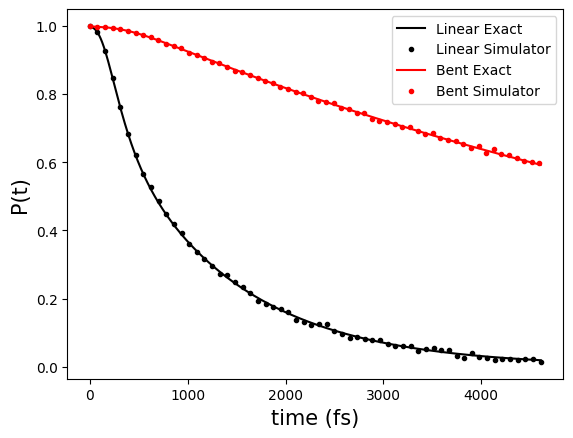

In [ ]:
#plot
hbar_evfs = 0.6582119569
plt.plot(time_linear*hbar_evfs, Rhot_linear[0,:].real,'k-', label = "Linear Exact")
plt.plot(time_q_linear*hbar_evfs,Pa_q_linear[:,0],'k.',label = 'Linear Simulator')
plt.plot(time_bent*hbar_evfs, Rhot_bent[0,:].real,'r-', label = "Bent Exact")
plt.plot(time_q_bent*hbar_evfs,Pa_q_bent[:,0],'r.',label = 'Bent Simulator')
plt.xlabel('time (fs)',fontsize=15)
plt.ylabel('P(t)',fontsize=15)
plt.legend(loc = 'upper right')

#Run the circuit in real quantum computer

In [ ]:
#you'll need to create an IBM Cloud account and a quantum service instance.
#replace "MY_IBM_QUANTUM_TOKEN" to your IBM Cloud account token
service = QiskitRuntimeService(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
# get a real backend from the runtime service
backend = service.backend('ibm_sherbrooke')

print('real backend',backend)
# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)
print('simulation backend',backend_sim)

real backend <IBMBackend('ibm_sherbrooke')>
simulation backend AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['reset', 'x', 'sx', 'measure', 'ecr', 'id']>)


In [ ]:
print(backend_sim)
print(backend_sim.operation_names)

AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['reset', 'x', 'sx', 'measure', 'ecr', 'id']>)
['delay', 'reset', 'x', 'rz', 'sx', 'measure', 'ecr', 'for_loop', 'id', 'if_else', 'switch_case']


##Get the transpiled circuit



In [ ]:
ncirq_sim = 40

In [ ]:
time_q_linear, qc_listl, normfac_listl = cons_qcsampler_walsh(time_linear, Gt_linear, ncirq_sim, backend = backend_sim, level=3, Nrepeat=10)

istep 0 j 0 level 3 depth 6
istep 0 depth 6 1.0000000000004305
istep 1 j 0 level 3 depth 10
istep 1 depth 10 1.00823598679333
istep 2 j 0 level 3 depth 10
istep 2 depth 10 1.0354142245310989
istep 3 j 0 level 3 depth 10
istep 3 depth 10 1.0698070301310245
istep 4 j 0 level 3 depth 10
istep 4 depth 10 1.1016406901069413
istep 5 j 0 level 3 depth 10
istep 5 depth 10 1.1289420690500578
istep 6 j 0 level 3 depth 10
istep 6 depth 10 1.1524827414853518
istep 7 j 0 level 3 depth 10
istep 7 depth 10 1.1732951788088888
istep 8 j 0 level 3 depth 10
istep 8 depth 10 1.192122172452022
istep 9 j 0 level 3 depth 10
istep 9 depth 10 1.2094205596056402
istep 10 j 0 level 3 depth 10
istep 10 depth 10 1.2254559324109087
istep 11 j 0 level 3 depth 10
istep 11 depth 10 1.2403818787749696
istep 12 j 0 level 3 depth 10
istep 12 depth 10 1.2542913459530969
istep 13 j 0 level 3 depth 10
istep 13 depth 10 1.2672467440331114
istep 14 j 0 level 3 depth 10
istep 14 depth 10 1.2792964920803074
istep 15 j 0 level 3

In [ ]:
time_q_bent, qc_listb, normfac_listb = cons_qcsampler_walsh(time_bent, Gt_bent, 40, backend = backend_sim, level=3, Nrepeat=10)

istep 0 j 0 level 3 depth 13
istep 0 depth 13 1.0000000000000002
istep 1 j 0 level 3 depth 15
istep 1 depth 15 1.0002119753078078
istep 2 j 0 level 3 depth 15
istep 2 depth 15 1.0008476710209437
istep 3 j 0 level 3 depth 15
istep 3 depth 15 1.0020087454620838
istep 4 j 0 level 3 depth 15
istep 4 depth 15 1.0037351206536547
istep 5 j 0 level 3 depth 15
istep 5 depth 15 1.0059348105012096
istep 6 j 0 level 3 depth 15
istep 6 depth 15 1.0084656916093147
istep 7 j 0 level 3 depth 17
istep 7 depth 17 1.0112057886033075
istep 8 j 0 level 3 depth 17
istep 8 depth 17 1.0140715408906227
istep 9 j 0 level 3 depth 17
istep 9 depth 17 1.0170113900678346
istep 10 j 0 level 3 depth 17
istep 10 depth 17 1.0199950617121767
istep 11 j 0 level 3 depth 17
istep 11 depth 17 1.0230051441077246
istep 12 j 0 level 3 depth 17
istep 12 depth 17 1.026031652139054
istep 13 j 0 level 3 depth 17
istep 13 depth 17 1.0290687897899389
istep 14 j 0 level 3 depth 17
istep 14 depth 17 1.0321130976691042
istep 15 j 0 lev

##run the circuit

In [ ]:
#replace backend_sim to backend for running in the real quantum device
Paq_l_sim = qcsampler(qc_listl, normfac_listl, backend = backend_sim, Nshots = 20000)
#Paq_l = qcsampler(qc_listl, normfac_listl, backend = backend, Nshots = 20000)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [ ]:
Paq_b_sim = qcsampler(qc_listb, normfac_listb, backend = backend_sim, Nshots = 20000)
#Paq_b = qcsampler(qc_listb, normfac_listb, backend = backend, Nshots = 20000)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


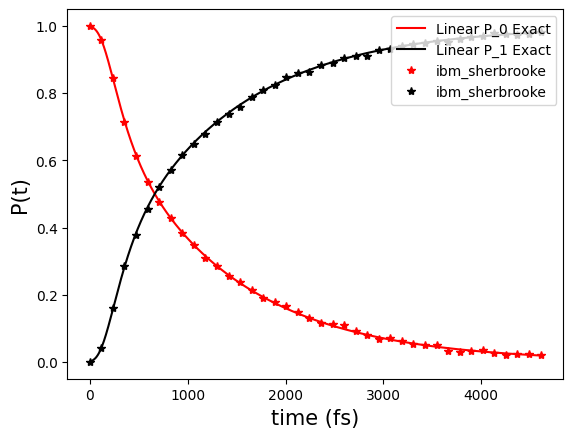

In [ ]:
str_back = 'ibm_sherbrooke'
#plot
hbar_evfs = 0.6582119569
plt.plot(time_linear*hbar_evfs, Rhot_linear[0,:].real,'r-', label = "Linear P_0 Exact")
plt.plot(time_linear*hbar_evfs, Rhot_linear[3,:].real,'k-', label = "Linear P_1 Exact")
plt.plot(time_q_linear*hbar_evfs,Paq_l_sim[:,0],'r*',label = str_back)
plt.plot(time_q_linear*hbar_evfs,Paq_l_sim[:,3],'k*',label = str_back)

# plt.plot(time_bent*hbar_evfs, Rhot_bent[0,:].real,'k-', label = "Bent Exact")
# plt.plot(time_bent*hbar_evfs, Rhot_bent[1,:].real,'r-', label = "Bent Exact")
# plt.plot(time_q_bent*hbar_evfs,Paq_b_sim[:,0],'k*',label = str_back)
# plt.plot(time_q_bent*hbar_evfs,Paq_b_sim[:,1],'r*',label = str_back)

plt.xlabel('time (fs)',fontsize=15)
plt.ylabel('P(t)',fontsize=15)
plt.legend(loc = 'upper right')